


<h1>NOTEBOOK 4 - Modelagem do cenário 01</h1>

Esse notebook apresenta as etapas de pré-processamento, modelagem, validação cruzada e apresentação dos resultados para o cenário 1 do TCC

# **Pré-Processamento dos Dados**

### Instalação das Bibliotecas Sktime e Scikeras

In [1]:
pip install sktime[all_extras]

### Instalação das Bibliotecas Matplotlib, Numpy e Pandas

In [2]:
from sktime.utils.plotting import plot_series
import matplotlib
import numpy as np
import pandas as pd
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_squared_error
from math import sqrt
import seaborn as sns

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importação da base de dados mensal

In [4]:
#Importação das séries de vazão e precipitação
df = pd.read_csv('df.csv', parse_dates=['Data'], index_col='Data')
df.index=df.index.to_period("M")
df.head()

,Vazao,Precipitacao
Data,,
1941-01,116.336800,198.68
1941-02,91.653729,121.83
1941-03,100.489190,119.51
1941-04,90.289133,61.22
1941-05,60.699858,19.46


## Transformação das Curvas

In [5]:
#Funções para reversão das transformações
def power_2(x):
  return(np.power(x,2))

def base_10(x):
  return(np.power(10,x))

In [6]:
#Transformações: log(vazão) e raiz(precipitação)
from sklearn.preprocessing import FunctionTransformer

transformer_log = FunctionTransformer(np.log10, inverse_func = base_10 , validate = True,check_inverse=False)
transformer_sqrt = FunctionTransformer(np.sqrt, inverse_func= power_2, validate = True,check_inverse=False)

df[['Vazao']] = transformer_log.fit_transform(df[['Vazao']])
df[['Precipitacao']] = transformer_sqrt.fit_transform(df[['Precipitacao']])
df.head()

,Vazao,Precipitacao
Data,,
1941-01,2.065717,14.095389
1941-02,1.962150,11.037663
1941-03,2.002119,10.932063
1941-04,1.955635,7.824321
1941-05,1.783188,4.411349


## Normalização dos Dados

In [7]:
#Normalização na escala de 0.1 a 0.9
from sklearn.preprocessing import MinMaxScaler

scaler_1 = MinMaxScaler(feature_range=(0.1,0.9))
scaler_2 = MinMaxScaler(feature_range=(0.1,0.9))

df[['Vazao']] = scaler_1.fit_transform(df[['Vazao']])
df[['Precipitacao']] = scaler_2.fit_transform(df[['Precipitacao']])
df.head()

,Vazao,Precipitacao
Data,,
1941-01,0.635201,0.553585
1941-02,0.574807,0.455188
1941-03,0.598114,0.451790
1941-04,0.571008,0.351784
1941-05,0.470447,0.241956


## Divisão da Base de Dados

In [8]:
#Divisão da base em treino e teste
y=df['Vazao']
X=df.drop('Vazao',axis=1)

from sktime.forecasting.model_selection import temporal_train_test_split

y_train,y_test,x_train,x_test= temporal_train_test_split(y,X,test_size=0.25)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

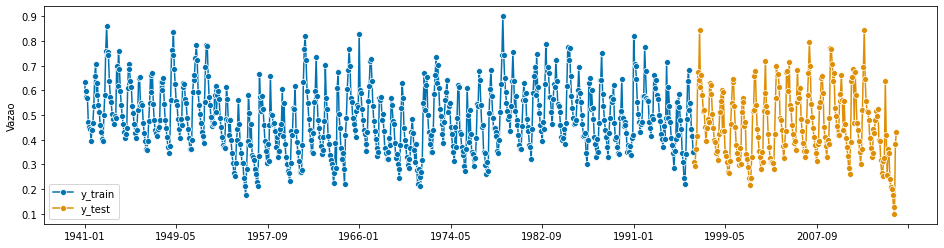

In [9]:
plot_series(y_train,y_test, labels=["y_train", "y_test"])

## Definição dos Horizontes de plotagem e previsão

In [10]:
#Definição do período de plotagem dos dados
y_train_menor=y_train[600:]

#Definição do horizonte de previsão
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)

# **Aplicação dos Modelos estatísticos**

## Modelo Naive (referência)

In [11]:
#Ajuste do Naive
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

forecaster_naive = NaiveForecaster(strategy="last", sp=12)
forecaster_naive.fit(y_train)

NaiveForecaster(sp=12)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

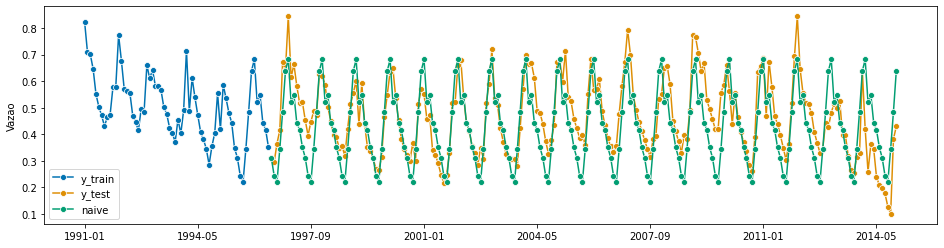

In [12]:
#Previsões do Naive
y_pred_naive = forecaster_naive.predict(fh)

plot_series(y_train_menor, y_test, y_pred_naive, labels=["y_train", "y_test", "naive"])

## Modelo AutoARIMA (referência)

In [13]:
#Ajuste do AutoARIMA
from sktime.forecasting.arima import AutoARIMA

forecaster_autoarima = AutoARIMA(start_p=1, d=None, start_q=1, max_p=4, max_q=4, start_P=1, D=None, start_Q=1, max_P=4, max_Q=4, 
                                 sp=12, seasonal=True, stationary=True, suppress_warnings=True, information_criterion='aic', scoring='mse')
forecaster_autoarima.fit(y_train)

print(forecaster_autoarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  666
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 883.609
Date:                              Sat, 16 Apr 2022   AIC                          -1753.218
Time:                                      01:08:34   BIC                          -1721.709
Sample:                                           0   HQIC                         -1741.010
                                              - 666                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.001      1.635      0.102      -0.000       0.003
ar.L1          0.83

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

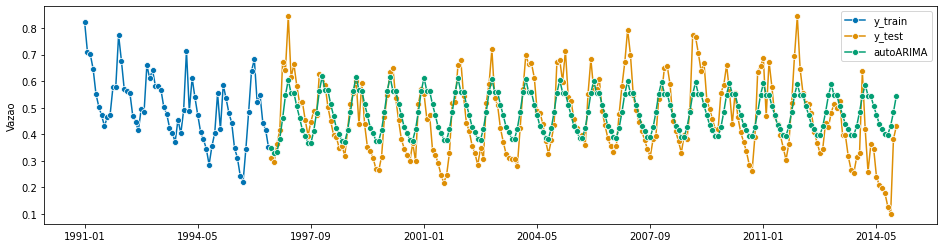

In [14]:
#Previsões do AutoARIMA
y_pred_autoarima = forecaster_autoarima.predict(fh)

plot_series(y_train_menor, y_test, y_pred_autoarima, labels=["y_train", "y_test", "autoARIMA"])

## Modelo AutoARIMA exógeno

In [15]:
#Ajuste do AutoARIMA exógeno
from sktime.forecasting.arima import AutoARIMA

forecaster_autoarima_exo = AutoARIMA(start_p=1, d=None, start_q=1, max_p=4, max_q=4, start_P=1, D=None, start_Q=1, max_P=4, max_Q=4, 
                                     sp=12, seasonal=True, stationary=True, suppress_warnings=True, information_criterion='aic', scoring='mse')
forecaster_autoarima_exo.fit(y_train,X=x_train)

print(forecaster_autoarima_exo.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  666
Model:             SARIMAX(1, 0, 1)x(3, 0, [1, 2, 3], 12)   Log Likelihood                1067.652
Date:                                    Sat, 16 Apr 2022   AIC                          -2113.305
Time:                                            01:18:05   BIC                          -2063.790
Sample:                                        01-31-1941   HQIC                         -2094.121
                                             - 06-30-1996                                         
Covariance Type:                                      opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0020      0.002      1.060 

In [16]:
#Ajuste do AutoARIMA exógeno - graus 1 ou 2
from sktime.forecasting.arima import AutoARIMA

forecaster_autoarima_exo_g2 = AutoARIMA(start_p=1, d=None, start_q=1, max_p=2, max_q=2, start_P=1, D=None, start_Q=1, max_P=2, max_Q=2, 
                                        sp=12, seasonal=True, stationary=True, suppress_warnings=True, information_criterion='aic', scoring='mse')
forecaster_autoarima_exo_g2.fit(y_train,X=x_train)

print(forecaster_autoarima_exo_g2.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  666
Model:             SARIMAX(2, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood                1063.866
Date:                                 Sat, 16 Apr 2022   AIC                          -2109.732
Time:                                         01:20:36   BIC                          -2069.220
Sample:                                     01-31-1941   HQIC                         -2094.036
                                          - 06-30-1996                                         
Covariance Type:                                   opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0035      0.009      0.394      0.693      -0.014  

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

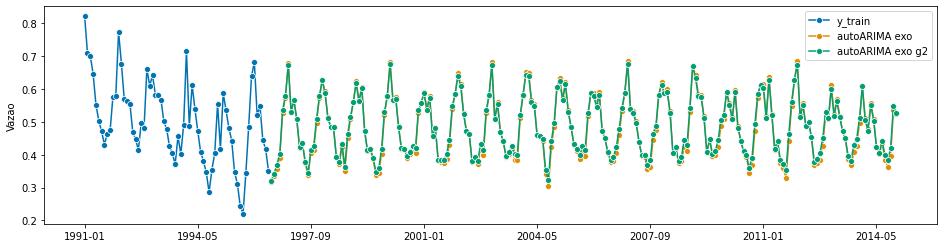

In [17]:
#Comparação das previsões dos AutoARIMA exógenos

y_pred_autoarima_exo = forecaster_autoarima_exo.predict(fh,X=x_test)
y_pred_autoarima_exo_g2 = forecaster_autoarima_exo_g2.predict(fh,X=x_test)

plot_series(y_train_menor, y_pred_autoarima_exo, y_pred_autoarima_exo_g2, labels=["y_train", "autoARIMA exo", "autoARIMA exo g2"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

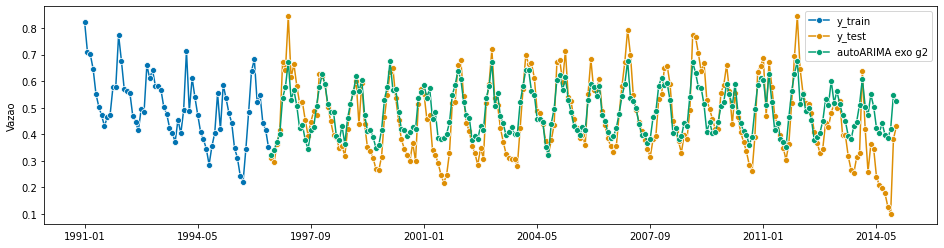

In [18]:
#Plotando a série prevista pelo AutoARIMA exógeno considerado
plot_series(y_train_menor, y_test, y_pred_autoarima_exo_g2, labels=["y_train", "y_test", "autoARIMA exo g2"])

## Modelo SARIMAX

In [19]:
#Ajuste do SARIMAX
from sktime.forecasting.arima import ARIMA
forecaster_arima_exo = ARIMA(
    order=(1,0,1), seasonal_order=(1,0,1, 12),
    maxiter=100,
    suppress_warnings=True,
    time_varying_regression=True
)

forecaster_arima_exo.fit(y_train,X=x_train)
print(forecaster_arima_exo.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  666
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                1073.350
Date:                            Sat, 16 Apr 2022   AIC                          -2132.700
Time:                                    01:20:43   BIC                          -2101.191
Sample:                                01-31-1941   HQIC                         -2120.492
                                     - 06-30-1996                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     9.888e-05   8.44e-05      1.172      0.241   -6.64e-05       0.000
Precipitacao     0.4135      

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

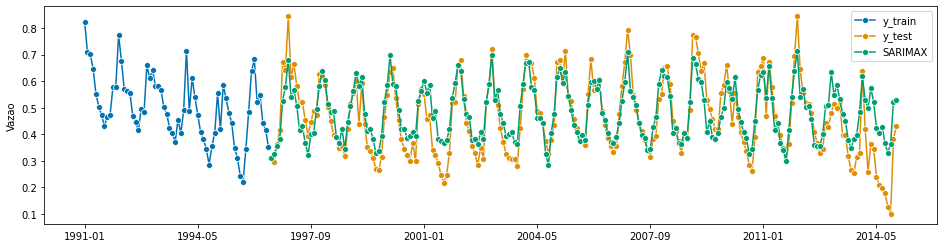

In [20]:
#Previsões do SARIMAX
y_pred_arima_exo = forecaster_arima_exo.predict(fh,X=x_test)
plot_series(y_train_menor, y_test, y_pred_arima_exo, 
            labels=["y_train", "y_test", "SARIMAX"])

## Modelo Prophet

In [21]:
#Ajuste do Prophet
from sktime.forecasting.fbprophet import Prophet

z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=222)
ds=df['Precipitacao']
ds = ds.to_timestamp(freq="M")
ds_train, ds_test = temporal_train_test_split(ds, test_size=222)

forecaster_prophet = Prophet(
    seasonality_mode="additive",
    n_changepoints=int(len(y_train) / 12),
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

forecaster_prophet.fit(z_train,X=ds_train)



Prophet(daily_seasonality=False, n_changepoints=55, weekly_seasonality=False,
        yearly_seasonality=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

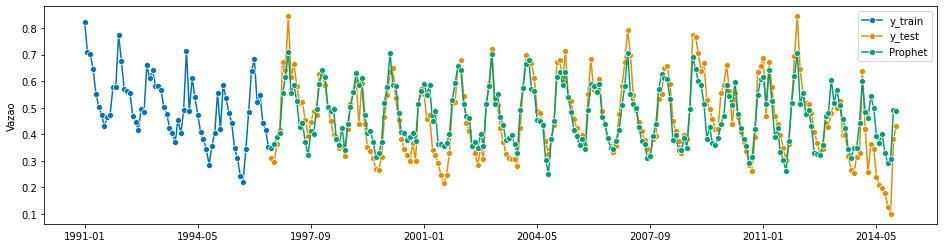

In [22]:
#Previsões do Prophet
y_pred_prophet= forecaster_prophet.predict(fh.to_relative(cutoff=y_train.index[-1]),ds_test )
y_pred_prophet.index = y_test.index

plot_series(y_train_menor, y_test, y_pred_prophet, labels=["y_train", "y_test", "Prophet"])

## Comparação entre os modelos sem validação cruzada

In [23]:
print('MAPE')
print('Naive :        ',mean_absolute_percentage_error(y_test, y_pred_naive,symmetric=False).round(5))
print('AutoARIMA :    ',mean_absolute_percentage_error(y_test, y_pred_autoarima,symmetric=False).round(5))
print('AutoARIMA exo :',mean_absolute_percentage_error(y_test, y_pred_autoarima_exo_g2,symmetric=False).round(5))
print('SARIMAx :      ',mean_absolute_percentage_error(y_test, y_pred_arima_exo,symmetric=False).round(5))
print('Prophet :      ',mean_absolute_percentage_error(y_test, y_pred_prophet,symmetric=False).round(5))
print('MSE')
print('Naive :       ',mean_absolute_percentage_error(y_test, y_pred_naive,symmetric=False).round(5))
print('AutoARIMA :   ',mean_squared_error(y_test, y_pred_autoarima).round(5))
print('AutoARIMA exo :',mean_squared_error(y_test, y_pred_autoarima_exo_g2).round(5))
print('SARIMAx :      ',mean_squared_error(y_test, y_pred_arima_exo,symmetric=False).round(5))
print('Prophet :      ',mean_squared_error(y_test, y_pred_prophet).round(5))

MAPE
Naive :         0.19152
AutoARIMA :     0.21085
AutoARIMA exo : 0.18838
SARIMAx :       0.16482
Prophet :       0.14683
MSE
Naive :        0.19152
AutoARIMA :    0.00949
AutoARIMA exo : 0.00716
SARIMAx :       0.00587
Prophet :       0.0049


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

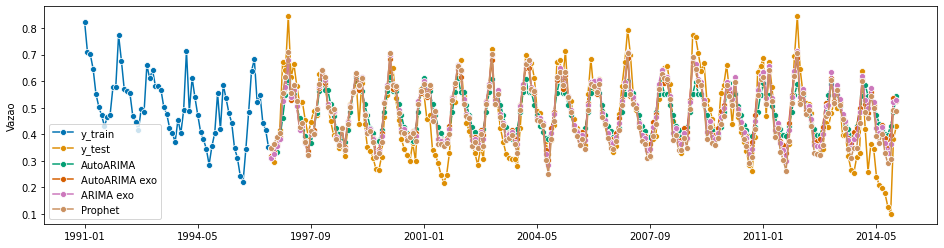

In [24]:
#Plotagem das previsões
plot_series(y_train_menor, y_test,
            y_pred_autoarima,
            y_pred_autoarima_exo,
            y_pred_arima_exo,
            y_pred_prophet,
            labels=["y_train", "y_test", 
                    'AutoARIMA',
                    'AutoARIMA exo',
                    'ARIMA exo',
                    'Prophet'])

## Validação Cruzada dos modelos

In [25]:
#Importação das Bibliotecas de CV e definição das janelas

from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.performance_metrics.forecasting import MeanSquaredError

cv = SlidingWindowSplitter(fh=60, window_length=300, step_length = 36)


In [26]:
#CV do modelo Naive
df_naive = evaluate(forecaster=forecaster_naive, y=y, cv=cv, strategy="refit", return_data=True)

df_naive_mse = evaluate(forecaster=forecaster_naive, y=y, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [27]:
#CV do modelo AutoARIMA
df_autoarima = evaluate(forecaster=forecaster_autoarima, y=y, cv=cv, strategy="refit", return_data=True)

df_autoarima_mse = evaluate(forecaster=forecaster_autoarima, y=y, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,1)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(2,0,3)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,1)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(2,0,3)[12]           (if you do not want to see these warnings, run with error_action="

In [28]:
#CV do modelo AutoARIMA exógeno
df_autoarima_exo = evaluate(forecaster=forecaster_autoarima_exo_g2, y=y, X=X, cv=cv, strategy="refit", return_data=True)

df_autoarima_exo_mse = evaluate(forecaster=forecaster_autoarima_exo_g2, y=y, X=X, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [29]:
#CV do modelo SARIMAX
df_arima_exo = evaluate(forecaster=forecaster_arima_exo, y=y, X=X, cv=cv, strategy="refit", return_data=True)

df_arima_exo_mse = evaluate(forecaster=forecaster_arima_exo, y=y, X=X, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [30]:
#CV do modelo Prophet
dsnovo=df.drop('Vazao',axis=1)
dsnovo=dsnovo.to_timestamp(freq='M')

df_prophet = evaluate(forecaster=forecaster_prophet, y=z,X=dsnovo, cv=cv, strategy="refit", return_data=True)

df_prophet_mse = evaluate(forecaster=forecaster_prophet, y=z,X=dsnovo, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [31]:
#Métricas das CVs dos modelos estatísticos
print('Média sMAPE dos modelos da Validação Cruzada:')
print('Naive :         ',round(df_naive['test_MeanAbsolutePercentageError'].mean(),5))
print('AutoARIMA :     ',round(df_autoarima['test_MeanAbsolutePercentageError'].mean(),5))
print('AutoARIMA exo : ',round(df_autoarima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('SARIMAx :       ',round(df_arima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('Prophet :       ',round(df_prophet['test_MeanAbsolutePercentageError'].mean(),5))
print('Média MSE dos modelos da Validação Cruzada:')
print('Naive :        ',round(df_naive_mse['test_MeanSquaredError'].mean(),5))
print('AutoARIMA :    ',round(df_autoarima_mse['test_MeanSquaredError'].mean(),5))
print('AutoARIMA exo :',round(df_autoarima_exo_mse['test_MeanSquaredError'].mean(),5))
print('SARIMAx :      ',round(df_arima_exo_mse['test_MeanSquaredError'].mean(),5))
print('Prophet :      ',round(df_prophet_mse['test_MeanSquaredError'].mean(),5))

Média sMAPE dos modelos da Validação Cruzada:
Naive :          0.1177
AutoARIMA :      0.13565
AutoARIMA exo :  0.08244
SARIMAx :        0.08131
Prophet :        0.13506
Média MSE dos modelos da Validação Cruzada:
Naive :         0.00721
AutoARIMA :     0.00808
AutoARIMA exo : 0.00304
SARIMAx :       0.00299
Prophet :       0.00953


# **Construção e Aplicação das Redes Neurais**

##Pré-Processamento

In [32]:
#Importação de bibliotecas
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_seed
from keras.layers import Dropout

## Rede MLP

In [33]:
#Construção da rede neural
modelDense = keras.models.Sequential()
modelDense.add(keras.layers.Dense(16, activation='tanh', input_dim=1))
modelDense.add(keras.layers.Dense(4, activation='tanh'))
modelDense.add(Dropout(0.2))
modelDense.add(keras.layers.Dense(1, activation='linear'))
modelDense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Definição de estado
seed(2)
set_seed(2)

#Definição de parâmetros de ajuste
batch_size = 64
epochs = 100
learning_rate = 0.01

#Ajuste da rede
modelDense.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])
hist_dense = modelDense.fit(x=x_train,y=y_train, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

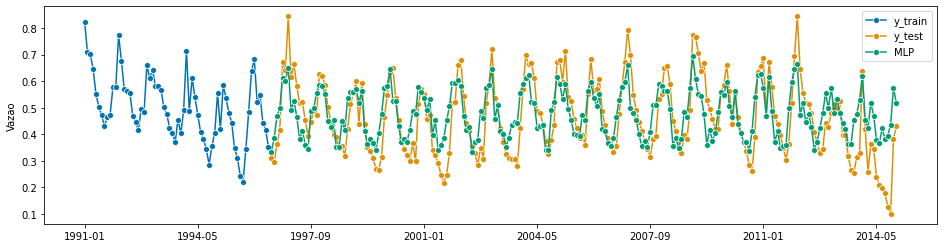

In [35]:
#Previsão e métricas da rede
pred_dense = modelDense.predict(x_test).reshape(-1)
y_pred_dense=pd.Series(pred_dense, index=y_test.index)

plot_series(y_train_menor, y_test,
            y_pred_dense,
            labels=["y_train", "y_test", 
                    'MLP'])

## Rede Recorrente

In [36]:
#Criação da função time_step
def create_dataset_time_step(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [37]:
#Definição do time step e bases de treino e teste
time_steps = 3

X_train_ts, y_train_ts = create_dataset_time_step(x_train,y_train, time_steps)
X_test_ts, y_test_ts = create_dataset_time_step(x_test,y_test, time_steps)

print(X_train_ts.shape, y_train_ts.shape)

(663, 3, 1) (663,)


In [38]:
#Construção da rede neural recorrente
modelSimpleRNN = keras.models.Sequential()
modelSimpleRNN.add(keras.layers.SimpleRNN(16, activation='tanh', return_sequences=True, input_shape=(X_train_ts.shape[1],X_train_ts.shape[2])))
modelSimpleRNN.add(keras.layers.SimpleRNN(4, activation='tanh', return_sequences=False))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(keras.layers.Dense(1, activation='linear'))
modelSimpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 16)             288       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 84        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 377
Trainable params: 377
Non-trainable params: 0
_________________________________________________________________


In [39]:
#Definição de estado
seed(2)
set_seed(2)

#Definição de parâmetros de ajuste
batch_size = 64
epochs = 100
learning_rate = 0.01

#Ajuste da RNR
modelSimpleRNN.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate,decay=0.001),metrics=['mse'])
hist_SimpleRNN = modelSimpleRNN.fit(x=X_train_ts, y=y_train_ts, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

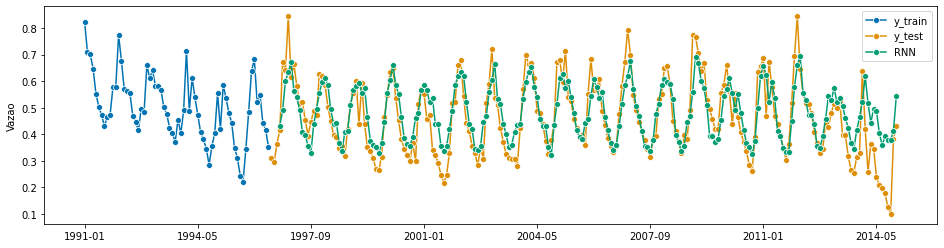

In [40]:
#Previsão e métricas da rede
pred_SimpleRNN = modelSimpleRNN.predict(X_test_ts)
y_pred_SimpleRNN=pd.Series(pred_SimpleRNN.reshape(-1), index=y_test.index[time_steps::])

plot_series(y_train_menor, y_test,
            y_pred_SimpleRNN,
            labels=["y_train", "y_test",
                    'RNN'
                    ])

**Comparando as duas redes**

In [41]:
#Métricas
print('MAPE')
print('MLP   ',mean_absolute_percentage_error(y_test, pred_dense).round(5))
print('RNN   ',mean_absolute_percentage_error(y_test_ts, pred_SimpleRNN).round(5))

print('MSE')
print('MLP :',mean_squared_error(y_test, pred_dense).round(5))
print('RNN   ',mean_squared_error(y_test_ts, pred_SimpleRNN).round(5))

MAPE
MLP    0.17601
RNN    0.14989
MSE
MLP : 0.00902
RNN    0.00739


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

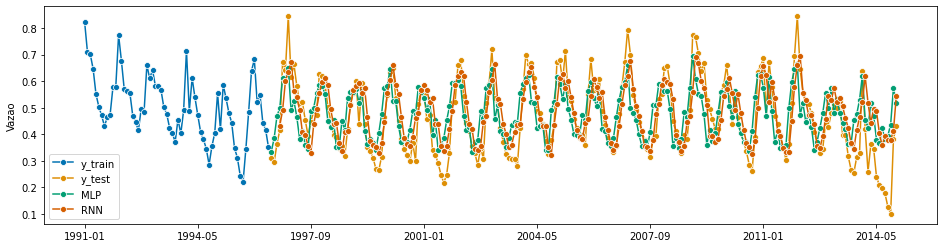

In [42]:
#Gráficos
plot_series(y_train_menor, y_test,
            y_pred_dense,
            y_pred_SimpleRNN,
            labels=["y_train", "y_test", 
                    'MLP',
                    'RNN'
                    ])

**Gráfico dos melhores modelos**

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

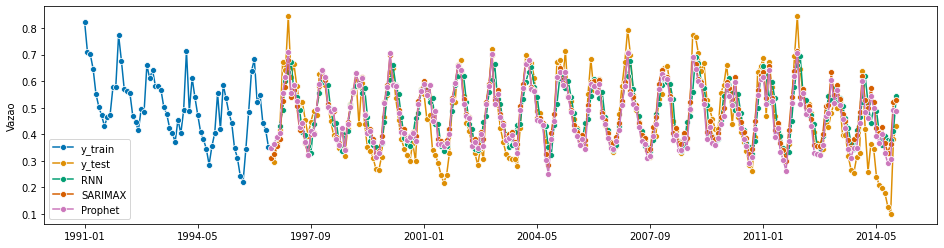

In [43]:
plot_series(y_train_menor, y_test,
            y_pred_SimpleRNN,
            y_pred_arima_exo,
            y_pred_prophet,
            labels=["y_train", "y_test", 
                    'RNN',
                    'SARIMAX',
                    'Prophet'])

## Validação Cruzada dos modelos

In [44]:
#Definindo X e y
X_cv = df['Precipitacao']
y_cv = df['Vazao']

dense_cv_y = []
dense_cv_pred = []

#Selecionando as linhas de treino e teste
fold = 0
for train, test in cv.split(y):
    fold+=1
    gp_test = np.arange(test-59,test+1)

    x_train_cv = X_cv[train]
    y_train_cv = y_cv[train]
    x_test_cv = X_cv[gp_test]
    y_test_cv = y_cv[gp_test]

#Contruindo a rede
    seed(2)
    set_seed(2)
    modelDense_cv = keras.models.Sequential()
    modelDense_cv.add(keras.layers.Dense(16, activation='tanh', input_dim=1))
    modelDense_cv.add(keras.layers.Dense(4, activation='tanh'))
    modelDense_cv.add(Dropout(0.2))
    modelDense_cv.add(keras.layers.Dense(1, activation='linear'))
    modelDense_cv.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])

 #CV do modelo MLP 
    modelDense_cv.fit(x_train_cv,y_train_cv,validation_data=(x_test_cv,y_test_cv),verbose=0,
              epochs=epochs)
    
    pred_dense_cv = modelDense_cv.predict(x_test_cv)
    
    dense_cv_y.append(y_test_cv)
    dense_cv_pred.append(pred_dense_cv)  
        
    mse_dense_fold = mean_squared_error(pred_dense_cv,y_test_cv)
    mape_dense_fold = mean_absolute_percentage_error(pred_dense_cv,y_test_cv)

In [45]:
#Definindo X, y e os passos temporais
X_cv = df['Precipitacao']
y_cv = df['Vazao']

SimpleRNN_cv_y = []
SimpleRNN_cv_pred = []
time_steps=3

#Selecionando as linhas de treino e teste
fold = 0
for train, test in cv.split(y):
    fold+=1
    gp_test = np.arange(test-59,test+1)

    x_train_cv = X_cv[train]
    y_train_cv = y_cv[train]
    x_test_cv = X_cv[gp_test]
    y_test_cv = y_cv[gp_test]    

    X_train_ts_cv, y_train_ts_cv = create_dataset_time_step(x_train_cv,y_train_cv, time_steps)
    X_test_ts_cv, y_test_ts_cv = create_dataset_time_step(x_test_cv,y_test_cv, time_steps)

    X_train_ts_cv=X_train_ts_cv.reshape(300-time_steps,time_steps,1)
    X_test_ts_cv=X_test_ts_cv.reshape(60-time_steps,time_steps,1)

#Contruindo a rede
    seed(2)
    set_seed(2)
    modelSimpleRNN_cv = keras.models.Sequential()
    modelSimpleRNN_cv.add(keras.layers.SimpleRNN(16, activation='tanh', return_sequences=True, input_shape=(X_train_ts.shape[1],X_train_ts.shape[2])))
    modelSimpleRNN_cv.add(keras.layers.SimpleRNN(4, activation='tanh', return_sequences=False))
    modelSimpleRNN_cv.add(Dropout(0.2))
    modelSimpleRNN_cv.add(keras.layers.Dense(1, activation='linear'))
    modelSimpleRNN_cv.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])
    modelSimpleRNN_cv.fit(x=X_train_ts_cv, y=y_train_ts_cv, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

    pred_SimpleRNN_cv = modelSimpleRNN_cv.predict(X_test_ts_cv)

    SimpleRNN_cv_y.append(y_test_ts_cv)
    SimpleRNN_cv_pred.append(pred_SimpleRNN_cv) 

    mse_SimpleRNN_fold = mean_squared_error(pred_SimpleRNN_cv,y_test_ts_cv)
    mape_SimpleRNN_fold = mean_absolute_percentage_error(pred_SimpleRNN_cv,y_test_ts_cv)

In [46]:
#Concatenando os arrays
dense_cv_y_1 = np.concatenate(dense_cv_y)
dense_cv_pred_1 = np.concatenate(dense_cv_pred)

SimpleRNN_cv_y_1 = np.concatenate(SimpleRNN_cv_y)
SimpleRNN_cv_pred_1 = np.concatenate(SimpleRNN_cv_pred)

In [47]:
#Cálculo das métricas da CV das redes
mape_dense_cv = mean_absolute_percentage_error(dense_cv_pred_1,dense_cv_y_1)
mse_dense_cv = mean_squared_error(dense_cv_pred_1,dense_cv_y_1)
print(f" MAPE - Validação Cruzada - MLP : {mape_dense_cv}") 
print(f" MSE - Validação Cruzada - MLP : {mse_dense_cv}") 
print("") 
mape_SimpleRNN_cv = mean_absolute_percentage_error(SimpleRNN_cv_pred_1,SimpleRNN_cv_y_1)
mse_SimpleRNN_cv = mean_squared_error(SimpleRNN_cv_pred_1,SimpleRNN_cv_y_1)
print(f" MAPE - Validação Cruzada - RNN :  {mape_SimpleRNN_cv}") 
print(f" MSE - Validação Cruzada - RNN :  {mse_SimpleRNN_cv}") 

 MAPE - Validação Cruzada - MLP : 0.15540468890586462
 MSE - Validação Cruzada - MLP : 0.007996522742692363

 MAPE - Validação Cruzada - RNN :  0.1397979989518005
 MSE - Validação Cruzada - RNN :  0.006662654275850216


# **Comparação dos Modelos**


**Sem Validação Cruzada**

In [59]:
print('MAPE')
print('Naive :        ',mean_absolute_percentage_error(y_test, y_pred_naive,symmetric=False).round(5))
print('AutoARIMA :    ',mean_absolute_percentage_error(y_test, y_pred_autoarima,symmetric=False).round(5))
print('AutoARIMA exo :',mean_absolute_percentage_error(y_test, y_pred_autoarima_exo_g2,symmetric=False).round(5))
print('SARIMAx :      ',mean_absolute_percentage_error(y_test, y_pred_arima_exo,symmetric=False).round(5))
print('Prophet :      ',mean_absolute_percentage_error(y_test, y_pred_prophet,symmetric=False).round(5))
print('MLP :          ',mean_absolute_percentage_error(y_test, pred_dense).round(5))
print('RNN :          ',mean_absolute_percentage_error(y_test_ts, pred_SimpleRNN).round(5))

print('MSE')
print('Naive :        ',mean_squared_error(y_test, y_pred_naive,symmetric=False).round(5))
print('AutoARIMA :    ',mean_squared_error(y_test, y_pred_autoarima,symmetric=False).round(5))
print('AutoARIMA exo :',mean_squared_error(y_test, y_pred_autoarima_exo_g2,symmetric=False).round(5))
print('SARIMAx :      ',mean_squared_error(y_test, y_pred_arima_exo,symmetric=False).round(5))
print('Prophet :      ',mean_squared_error(y_test, y_pred_prophet,symmetric=False).round(5))
print('MLP :          ',mean_squared_error(y_test, pred_dense).round(5))
print('RNN :          ',mean_squared_error(y_test_ts, pred_SimpleRNN).round(5))

MAPE
Naive :         0.19152
AutoARIMA :     0.21085
AutoARIMA exo : 0.18838
SARIMAx :       0.16482
Prophet :       0.14683
MLP :           0.17601
RNN :           0.14989
MSE
Naive :         0.00976
AutoARIMA :     0.00949
AutoARIMA exo : 0.00716
SARIMAx :       0.00587
Prophet :       0.0049
MLP :           0.00902
RNN :           0.00739


**Com Validação Cruzada**

In [60]:
print('Média sMAPE dos modelos da Validação Cruzada:')
print('Naive :         ',round(df_naive['test_MeanAbsolutePercentageError'].mean(),5))
print('AutoARIMA :     ',round(df_autoarima['test_MeanAbsolutePercentageError'].mean(),5))
print('AutoARIMA exo : ',round(df_autoarima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('SARIMAX :       ',round(df_arima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('Prophet :       ',round(df_prophet['test_MeanAbsolutePercentageError'].mean(),5))
print('MLP :         ',round(mape_dense_cv,5))
print('RNN :           ',round(mape_SimpleRNN_cv,5))
print('Média MSE dos modelos da Validação Cruzada:')
print('Naive :        ',round(df_naive_mse['test_MeanSquaredError'].mean(),5))
print('AutoARIMA :    ',round(df_autoarima_mse['test_MeanSquaredError'].mean(),5))
print('AutoARIMA exo :',round(df_autoarima_exo_mse['test_MeanSquaredError'].mean(),5))
print('SARIMAX :      ',round(df_arima_exo_mse['test_MeanSquaredError'].mean(),5))
print('Prophet :      ',round(df_prophet_mse['test_MeanSquaredError'].mean(),5))
print('MLP :          ',round(mse_dense_cv,5))
print('RNN :          ',round(mse_SimpleRNN_cv,5))

Média sMAPE dos modelos da Validação Cruzada:
Naive :          0.1177
AutoARIMA :      0.13565
AutoARIMA exo :  0.08244
SARIMAX :        0.08131
Prophet :        0.13506
MLP :          0.1554
RNN :            0.1398
Média MSE dos modelos da Validação Cruzada:
Naive :         0.00721
AutoARIMA :     0.00808
AutoARIMA exo : 0.00304
SARIMAX :       0.00299
Prophet :       0.00953
MLP :           0.008
RNN :           0.00666


# **Gráficos em Escala Real**

In [61]:
def inverter_escala(y,y_base,time_step=0):
  y_inv = scaler_1.inverse_transform(y.values.reshape(-1, 1))
  y_inv = transformer_log.inverse_transform(y_inv)
  y_inv = pd.Series(y_inv.reshape(-1), index=y_base.index[time_step::]) 
  return(y_inv)

In [62]:
y_train_menor_inv = inverter_escala(y_train_menor,y_train_menor)
y_test_inv = inverter_escala(y_test,y_test)
y_pred_SimpleRNN_inv = inverter_escala(y_pred_SimpleRNN,y_test,time_steps)
y_pred_dense_inv = inverter_escala(y_pred_dense,y_test)
y_pred_arima_exo_inv  = inverter_escala(y_pred_arima_exo,y_test)
y_pred_prophet_inv  = inverter_escala(y_pred_prophet,y_test)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

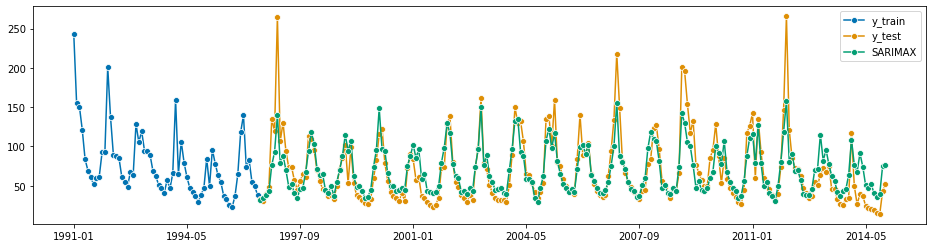

In [63]:
plot_series(y_train_menor_inv,y_test_inv, y_pred_arima_exo_inv,
            labels=["y_train", "y_test",
                    "SARIMAX"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

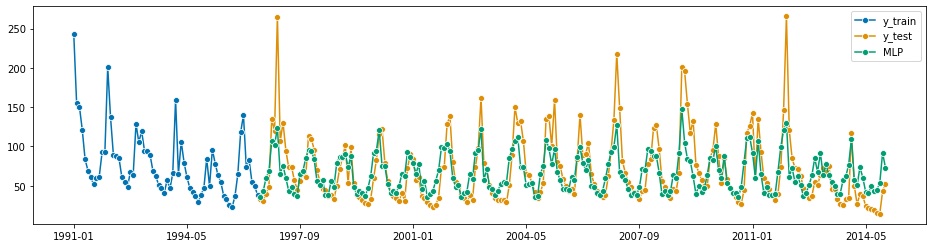

In [64]:
plot_series(y_train_menor_inv,y_test_inv, y_pred_dense_inv,
            labels=["y_train", "y_test",
                    "MLP"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

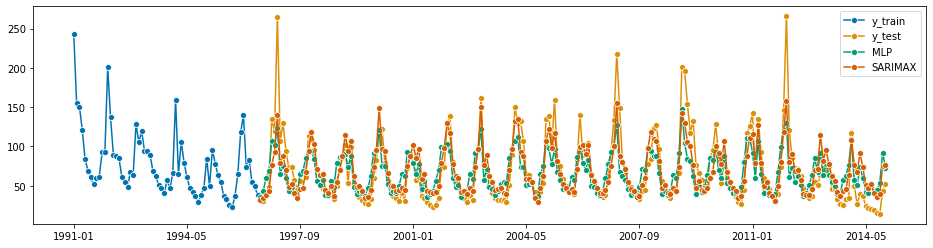

In [65]:
plot_series(y_train_menor_inv,y_test_inv,y_pred_dense_inv,
            y_pred_arima_exo_inv,
             labels=["y_train", "y_test", 
                    "MLP","SARIMAX"])